In [2]:
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
# Define datasets and directions
datasets = [
    "b4bqa"
    # orig filtered
    "medmcqa_orig_filtered",
    "medqa_4options_orig_filtered",
    # g2b
    "medqa_4options_g2b",
    "medqa_4options_g2b",
]

models = [
    "microsoft/phi-1",
    "microsoft/phi-1_5",
    "microsoft/phi-2",
    "microsoft/Phi-3-medium-4k-instruct",
    "mistralai/Mistral-7B-v0.3",
    # "Qwen/Qwen1.5-7B",
    "meta-llama/Llama-2-7b-hf",
    "meta-llama/Meta-Llama-3-8B",
    "mistralai/Mixtral-8x7B-v0.1",
    "mistralai/Mixtral-8x22B-v0.1",
    "meta-llama/Llama-2-70B-hf",
    "meta-llama/Meta-Llama-3-70B",
    # "Qwen/Qwen1.5-72B",
    "CohereForAI/c4ai-command-r-plus",
    "CohereForAI/aya-23-35B",
    "Qwen/Qwen2-72B",
    "Qwen/Qwen2-7B",
    # "Qwen/Qwen1.5-110B",
    "01-ai/Yi-1.5-34B",
    "gpt4",
    "gpt4o",
    "gpt35turbo",
    "claude_opus",
    "gemini_15_pro",
    "gemini_pro_1",
    "gemini_15_flash",
]

# Define a dictionary to map the original dataset names to the new names
model_name_map = {
    "microsoft-phi-1": "phi-1",
    "microsoft-phi-1_5": "phi-1_5",
    "microsoft-phi-2": "phi-2",
    "microsoft-Phi-3-medium-4k-instruct": "phi-3-medium",
    "CohereForAI-aya-23-35B": "c4ai-aya-23-35B",
    "CohereForAI-c4ai-command-r-plus": "c4ai-r-plus",
    "meta-llama-Llama-2-70B-hf": "llama-2-70B",
    "meta-llama-Llama-2-7b-hf": "llama-2-7B",
    "meta-llama-Meta-Llama-3-70B": "llama-3-70B",
    "meta-llama-Meta-Llama-3-8B": "llama-3-8B",
    "mistralai-Mixtral-8x22B-v0.1": "mixtral-8x22B",
    "mistralai-Mixtral-8x7B-v0.1": "mixtral-8x7B",
    "mistralai-Mistral-7B-v0.3": "mistral-7B",
    # "Qwen-Qwen1.5-72B": "qwen1.5-72B",
    # "Qwen-Qwen1.5-7B": "qwen1.5-7B",
    "Qwen-Qwen2-72B": "qwen2-72B",
    "Qwen-Qwen2-7B": "qwen2-7B",
    # "Qwen-Qwen1.5-110B": "qwen1.5-110B",
    "01-ai-Yi-1.5-34B": "yi-1.5-34B",
    "gpt4": "gpt4-0613",
    "gpt4o": "gpt-4o-2024-05-13",
    "gpt35turbo": "gpt-3.5-turbo-0125",
    "claude_opus": "claude-3-opus@20240229",
}


model_size_map = {
    "phi-1": "1.3",
    "phi-1_5": "1.3",
    "phi-2": "2.7",
    "phi-3-medium": "14",
    "c4ai-aya-23-35B": "35",
    "c4ai-r-plus": "104",
    "llama-2-70B": "70",
    "llama-2-7B": "7",
    "llama-3-70B": "70",
    "llama-3-8B": "8",
    "mixtral-8x22B": "176",
    "mixtral-8x7B": "56",
    "mistral-7B": "7",
    # "qwen1.5-72B": "72",
    # "qwen1.5-7B": "7",
    "qwen2-72B": "72",
    "qwen2-7B": "7",
    # "qwen1.5-110B": "110",
    "yi-1.5-34B": "34",
    "gpt4-0613": "1400",
    "gpt-4o-2024-05-13": "1400",
    "gpt-3.5-turbo-0125": "180",
    "claude-3-opus@20240229": "1000",
    "gemini_15_pro": "1000",
    "gemini_pro_1": "1000",
    "gemini_15_flash": "175"
}


replacement_directions = ["generic_to_brand", "none"]

## Model results


In [12]:
def load_model_results(model, direction):
    """
    Load the model results from a JSON file.

    Args:
    model (str): The model name.
    direction (str): The direction of replacements (e.g., brand_to_generic, generic_to_brand).

    Returns:
    pd.DataFrame: A DataFrame containing the model results.
    """
    results_file_path = f"b4b/{model}_results.json"

    if os.path.exists(results_file_path):
        with open(results_file_path, "r") as file:
            results_data = json.load(file)

        results = results_data["results"]
        results_list = []

        for dataset, metrics in results.items():
            for metric, value in metrics.items():
                if metric.startswith("acc"):
                    metric_name = metric.split(",")[0]
                    results_list.append([dataset, metric_name, value])

        df_results = pd.DataFrame(results_list, columns=["Dataset", "Metric", "Value"])
        df_results["Model"] = model
        df_results["Dataset"] = df_results["Dataset"]

        return df_results
    else:
        return pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])


def process_results(results_df):
    # Wrangle names to get pairs
    results_df["Direction"] = results_df["Dataset"].apply(
        lambda x: (
            "brand_to_generic"
            if "b2g" in x
            else "generic_to_brand" if "g2b" in x else "none"
        )
    )

    # If _b2g, _g2b, or b4b_ in name remove it from the name
    for term in ["_b2g", "_g2b", "b4b_", "_orig_filtered"]:
        results_df["Dataset"] = results_df["Dataset"].apply(
            lambda x: x.replace(term, "")
        )

    # Filter the results DataFrame to include only accuracy metrics
    results_df_filtered = results_df[results_df["Metric"] == "acc"]

    # filter out datasets if not contain medmcqa, medqa
    results_df_filtered = results_df_filtered[
        results_df_filtered["Dataset"].str.contains("medmcqa|medqa")
    ]

    # Pivot the DataFrame to have directions as columns
    pivot_results = results_df_filtered.pivot_table(
        index=["Dataset", "Model"], columns="Direction", values="Value"
    ).reset_index()

    # Replace 'b4b' with NaN
    pivot_results.replace("b4b", np.nan, inplace=True)

    # Drop the row with NaN
    pivot_results.dropna(subset=["Dataset"], inplace=True)

    # Calculate the average for each model
    average_df = (
        pivot_results.groupby("Model")[["generic_to_brand", "none"]]
        .mean()
        .reset_index()
    )

    # Assign the averages to 'b4b' dataset
    average_df["Dataset"] = "b4b"

    # Append the averages to the original DataFrame
    pivot_results = pd.concat([pivot_results, average_df], ignore_index=True)

    return pivot_results

In [41]:
# Initialize an empty DataFrame to store the final results
results_df = pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])
results_df = pd.read_csv('updated_all_model_results.csv')

In [42]:
results_df[results_df['Model']=='gpt4']

,Dataset,Metric,Value,Model,Direction
768,b4bqa,acc,0.949219,gpt4,none
769,medqa_4options,acc,0.923280,gpt4,none
770,medqa_4options,acc,0.899471,gpt4,generic_to_brand
771,medmcqa,acc,0.916667,gpt4,none
772,medmcqa,acc,0.887931,gpt4,generic_to_brand


In [43]:

# # replace model / with - in the model name
# for i in range(len(models)):
#     models[i] = models[i].replace("/", "-")

# Load and store the model results
for model in models:
    for direction in replacement_directions:
        df_model_results = load_model_results(model, direction)
        if not df_model_results.empty:
            results_df = pd.concat([results_df, df_model_results], ignore_index=True)

# # Save the results to a CSV file
# results_output_file_path = "tables/all_model_results.csv"
# results_df.to_csv(results_output_file_path, index=False)

print("\nModel Results found:")
print(results_df["Model"].unique())

processed_results = process_results(results_df)

# Assume processed_results is a pandas DataFrame and 'Model' is one of its columns
processed_results["Model"] = (
    processed_results["Model"].map(model_name_map).fillna(processed_results["Model"])
)


# sort by dataset and model
processed_results = processed_results.sort_values(by=["Dataset", "Model"])

processed_results_output_file_path = "tables/processed_model_results.csv"

# Save the processed results to a CSV file
processed_results.to_csv(processed_results_output_file_path, index=False)
processed_results


Model Results found:
['microsoft-phi-1' 'microsoft-phi-1_5' 'microsoft-phi-2'
 'microsoft-Phi-3-medium-4k-instruct' 'mistralai-Mistral-7B-v0.3'
 'meta-llama-Llama-2-7b-hf' 'meta-llama-Meta-Llama-3-8B'
 'mistralai-Mixtral-8x7B-v0.1' 'mistralai-Mixtral-8x22B-v0.1'
 'meta-llama-Llama-2-70B-hf' 'meta-llama-Meta-Llama-3-70B'
 'CohereForAI-c4ai-command-r-plus' 'CohereForAI-aya-23-35B'
 'Qwen-Qwen2-72B' 'Qwen-Qwen2-7B' '01-ai-Yi-1.5-34B' 'gpt4' 'gpt4o'
 'gpt35turbo' 'claude_opus' 'gemini_15_pro' 'gemini_pro_1'
 'gemini_15_flash']


Direction,Dataset,Model,generic_to_brand,none
47,b4b,c4ai-aya-23-35B,0.482234,0.507184
48,b4b,c4ai-r-plus,0.528758,0.582292
51,b4b,claude-3-opus@20240229,NaN,0.838567
52,b4b,gemini_15_flash,NaN,0.963408
53,b4b,gemini_15_pro,NaN,0.862229
...,...,...,...,...
42,medqa_4options,phi-2,0.417989,0.432099
39,medqa_4options,phi-3-medium,0.534392,0.567901
26,medqa_4options,qwen2-72B,0.740741,0.749559
27,medqa_4options,qwen2-7B,0.537037,0.572310


In [ ]:
# for generic_to_brand column that are NaN, replace with the value that is the same model, and avg medqa_4options and medmcqa on the same direction

# for each model, get the avg of medqa_4options and medmcqa
# for each model, get the avg of generic_to_brand
# for each model, replace NaN with the avg of generic_to_brand


In [47]:
set(processed_results['Model'])

{'c4ai-aya-23-35B',
 'c4ai-r-plus',
 'claude-3-opus@20240229',
 'gemini_15_flash',
 'gemini_15_pro',
 'gemini_pro_1',
 'gpt-3.5-turbo-0125',
 'gpt-4o-2024-05-13',
 'gpt4-0613',
 'llama-2-70B',
 'llama-2-7B',
 'llama-3-70B',
 'llama-3-8B',
 'mistral-7B',
 'mixtral-8x22B',
 'mixtral-8x7B',
 'phi-1',
 'phi-1_5',
 'phi-2',
 'phi-3-medium',
 'qwen2-72B',
 'qwen2-7B',
 'yi-1.5-34B'}

In [27]:
processed_results[processed_results['Model']=='gemini_15_flash']

Direction,Dataset,Model,generic_to_brand,none,Diff_generic_to_brand
52,b4b,gemini_15_flash,NaN,0.963408,NaN
6,medmcqa,gemini_15_flash,NaN,0.961207,NaN
29,medqa_4options,gemini_15_flash,NaN,0.965608,NaN


In [15]:
# append     "gpt4": "gpt4-0613", "gpt4o": "gpt-4o-2024-05-13", "gpt35turbo": "gpt-3.5-turbo-0125", "claude_opus": "claude-3-opus@20240229" to the processed_results
# append     "gemini_15_pro": "gemini-15-pro", "gemini_pro_1": "gemini-pro-1", "gemini_15_flash": "gemini-15-flash" to the processed_results


get b4b qa results

In [16]:
results_df
# keep only rows where Dataset=='b4bqa' and Metric=='acc'
b4bqa_results = results_df[
    (results_df["Dataset"] == "b4bqa") & (results_df["Metric"] == "acc")
]
# deduplicate the results
b4bqa_results = b4bqa_results.drop_duplicates(subset=["Model"])
# sort the results by Model size
b4bqa_results["Model Size"] = (
    b4bqa_results["Model"].map(model_name_map).map(model_size_map)
)
b4bqa_results["Model Size"] = pd.to_numeric(b4bqa_results["Model Size"])
b4bqa_results = b4bqa_results.sort_values(by="Model Size")

# drop column direction and metric
b4bqa_results = b4bqa_results.drop(columns=["Direction", "Metric", "Dataset"])

b4bqa_results

,Value,Model,Model Size
4,0.196429,microsoft-phi-1,1.3
52,0.280134,microsoft-phi-1_5,1.3
100,0.474888,microsoft-phi-2,2.7
196,0.703125,mistralai-Mistral-7B-v0.3,7.0
244,0.368304,meta-llama-Llama-2-7b-hf,7.0
676,0.804129,Qwen-Qwen2-7B,7.0
292,0.827009,meta-llama-Meta-Llama-3-8B,8.0
148,0.699777,microsoft-Phi-3-medium-4k-instruct,14.0
724,0.851562,01-ai-Yi-1.5-34B,34.0
580,0.784040,CohereForAI-aya-23-35B,35.0


/tmp/ipykernel_1145723/3874261935.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Value", data=b4bqa_results, palette="viridis")


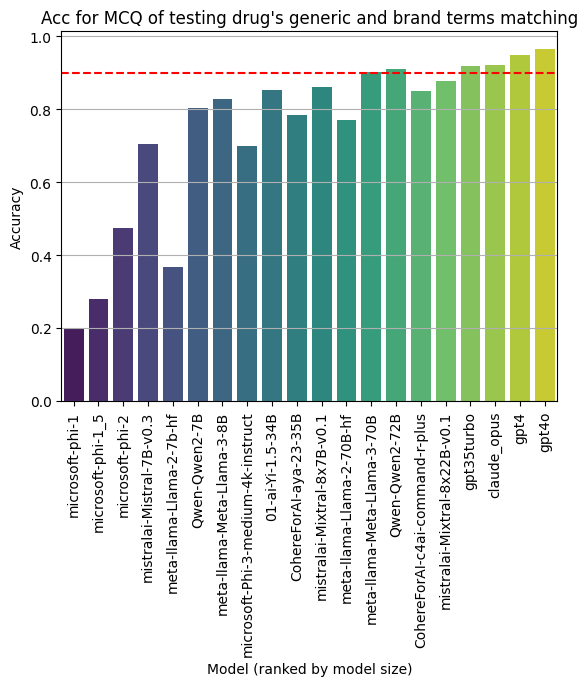

In [19]:
sns.barplot(x="Model", y="Value", data=b4bqa_results, palette="viridis")

plt.title("Acc for MCQ of testing drug's generic and brand terms matching")
plt.xlabel("Model (ranked by model size)")
plt.ylabel("Accuracy")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# add grid

# add a 0.9 line on y_axis
plt.axhline(y=0.9, color='r', linestyle='--', label="0.9")

plt.grid(axis="y")
plt.show()

## Latex tables

#### Dataset | Model | brand_to_generic | generic_to_brand | none


In [20]:
# Generate LaTeX table
latex_table = processed_results.to_latex(index=False, float_format="%.3f")

# Save LaTeX table to a file
with open("tables/model_results_table.tex", "w") as f:
    f.write(latex_table)
# Print the LaTeX table
## # Dataset | Model | brand_to_generic | generic_to_brand | none
print(latex_table)

\begin{tabular}{llrr}
\toprule
Dataset & Model & generic_to_brand & none \\
\midrule
b4b & c4ai-aya-23-35B & 0.482 & 0.507 \\
b4b & c4ai-r-plus & 0.529 & 0.582 \\
b4b & claude-3-opus@20240229 & NaN & 0.839 \\
b4b & gemini_15_flash & NaN & 0.963 \\
b4b & gemini_15_pro & NaN & 0.862 \\
b4b & gemini_pro_1 & NaN & 0.714 \\
b4b & gpt-3.5-turbo-0125 & NaN & 0.971 \\
b4b & gpt-4o-2024-05-13 & NaN & 0.889 \\
b4b & gpt4-0613 & NaN & 0.907 \\
b4b & llama-2-70B & 0.493 & 0.522 \\
b4b & llama-2-7B & 0.341 & 0.352 \\
b4b & llama-3-70B & 0.697 & 0.743 \\
b4b & llama-3-8B & 0.540 & 0.580 \\
b4b & mistral-7B & 0.485 & 0.528 \\
b4b & mixtral-8x22B & 0.646 & 0.688 \\
b4b & mixtral-8x7B & 0.578 & 0.617 \\
b4b & phi-1 & 0.229 & 0.232 \\
b4b & phi-1_5 & 0.333 & 0.328 \\
b4b & phi-2 & 0.397 & 0.420 \\
b4b & phi-3-medium & 0.569 & 0.626 \\
b4b & qwen2-72B & 0.728 & 0.754 \\
b4b & qwen2-7B & 0.544 & 0.590 \\
b4b & yi-1.5-34B & 0.598 & 0.645 \\
medmcqa & c4ai-aya-23-35B & 0.486 & 0.514 \\
medmcqa & c4ai-r-plus

In [21]:
# grab all results for b4bqa
b4bqa_results = processed_results[processed_results["Dataset"] == "b4bqa"]
b4bqa_results

Direction,Dataset,Model,generic_to_brand,none


### Model | none | generic_to_brand | Average | Difference


In [22]:
# Filter for the 'b4b' dataset
b4b_results = processed_results[processed_results["Dataset"] == "b4b"].copy()

# Calculate the average of original (none) and generic to brand
b4b_results["Average"] = b4b_results[["none", "generic_to_brand"]].mean(axis=1)

# Calculate the difference
b4b_results["Difference"] = b4b_results["generic_to_brand"] - b4b_results["none"]

# Select relevant columns for the LaTeX table
b4b_results = b4b_results[
    ["Model", "none", "generic_to_brand", "Average", "Difference"]
]

# Generate LaTeX table
latex_table_b4b = b4b_results.to_latex(index=False, float_format="%.3f")

# Save LaTeX table to a file
with open("tables/b4b_results_table.tex", "w") as f:
    f.write(latex_table_b4b)

# Print the LaTeX table
## # Model | none | generic_to_brand | Average | Difference
print(latex_table_b4b)

\begin{tabular}{lrrrr}
\toprule
Model & none & generic_to_brand & Average & Difference \\
\midrule
c4ai-aya-23-35B & 0.507 & 0.482 & 0.495 & -0.025 \\
c4ai-r-plus & 0.582 & 0.529 & 0.556 & -0.054 \\
claude-3-opus@20240229 & 0.839 & NaN & 0.839 & NaN \\
gemini_15_flash & 0.963 & NaN & 0.963 & NaN \\
gemini_15_pro & 0.862 & NaN & 0.862 & NaN \\
gemini_pro_1 & 0.714 & NaN & 0.714 & NaN \\
gpt-3.5-turbo-0125 & 0.971 & NaN & 0.971 & NaN \\
gpt-4o-2024-05-13 & 0.889 & NaN & 0.889 & NaN \\
gpt4-0613 & 0.907 & NaN & 0.907 & NaN \\
llama-2-70B & 0.522 & 0.493 & 0.508 & -0.029 \\
llama-2-7B & 0.352 & 0.341 & 0.347 & -0.011 \\
llama-3-70B & 0.743 & 0.697 & 0.720 & -0.046 \\
llama-3-8B & 0.580 & 0.540 & 0.560 & -0.040 \\
mistral-7B & 0.528 & 0.485 & 0.507 & -0.044 \\
mixtral-8x22B & 0.688 & 0.646 & 0.667 & -0.042 \\
mixtral-8x7B & 0.617 & 0.578 & 0.597 & -0.040 \\
phi-1 & 0.232 & 0.229 & 0.231 & -0.003 \\
phi-1_5 & 0.328 & 0.333 & 0.330 & 0.005 \\
phi-2 & 0.420 & 0.397 & 0.408 & -0.022 \\
phi-3-me

## Visualise difference in performance


In [23]:
# Calculate the differences
processed_results["Diff_generic_to_brand"] = (
    processed_results["generic_to_brand"] - processed_results["none"]
)

# Melt the DataFrame for plotting
melted_results = processed_results.melt(
    id_vars=["Dataset", "Model"],
    value_vars=["Diff_generic_to_brand"],
    var_name="Direction",
    value_name="Accuracy Difference",
)

melted_results

,Dataset,Model,Direction,Accuracy Difference
0,b4b,c4ai-aya-23-35B,Diff_generic_to_brand,-0.024950
1,b4b,c4ai-r-plus,Diff_generic_to_brand,-0.053533
2,b4b,claude-3-opus@20240229,Diff_generic_to_brand,NaN
3,b4b,gemini_15_flash,Diff_generic_to_brand,NaN
4,b4b,gemini_15_pro,Diff_generic_to_brand,NaN
...,...,...,...,...
64,medqa_4options,phi-2,Diff_generic_to_brand,-0.014109
65,medqa_4options,phi-3-medium,Diff_generic_to_brand,-0.033510
66,medqa_4options,qwen2-72B,Diff_generic_to_brand,-0.008818
67,medqa_4options,qwen2-7B,Diff_generic_to_brand,-0.035273


In [25]:
melted_results.Direction

0     Diff_generic_to_brand
1     Diff_generic_to_brand
2     Diff_generic_to_brand
3     Diff_generic_to_brand
4     Diff_generic_to_brand
              ...          
64    Diff_generic_to_brand
65    Diff_generic_to_brand
66    Diff_generic_to_brand
67    Diff_generic_to_brand
68    Diff_generic_to_brand
Name: Direction, Length: 69, dtype: object

/tmp/ipykernel_1145723/3882101965.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1145723/3882101965.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_1145723/3882101965.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1145723/3882101965.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


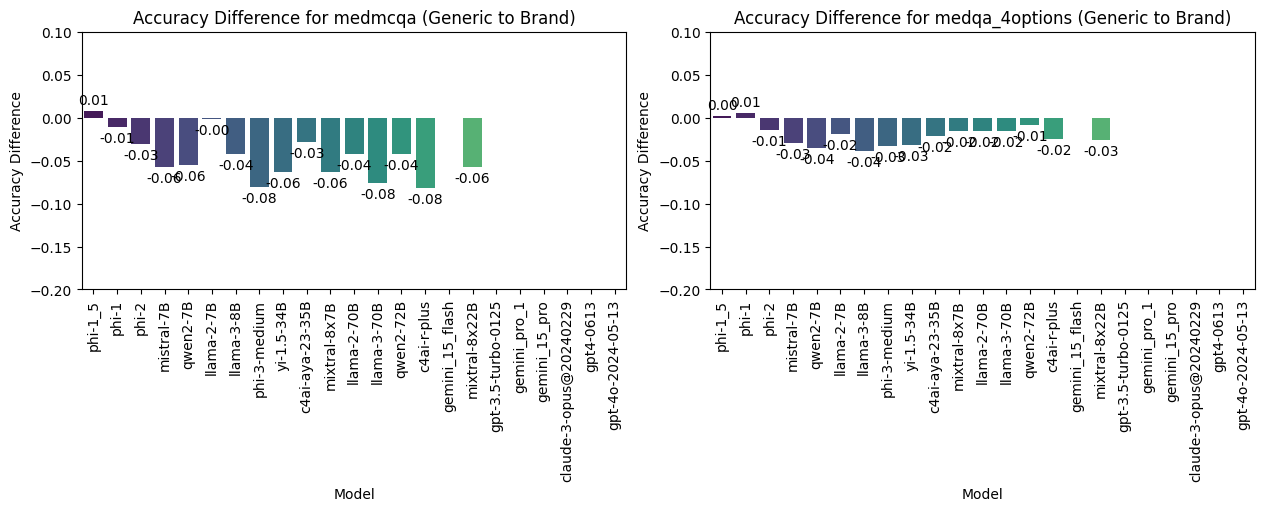

In [24]:
# Filter the DataFrame to only include 'Diff_generic_to_brand' direction
filtered_results = melted_results[
    melted_results["Direction"] == "Diff_generic_to_brand"
]

# Create a new column 'Model Size' in the DataFrame
filtered_results["Model Size"] = filtered_results["Model"].map(model_size_map)
filtered_results["Model Size"] = pd.to_numeric(filtered_results["Model Size"])

# Create bar plots for each task with filtered data
tasks = filtered_results["Dataset"].unique()
num_tasks = len(tasks)
ncols = 3  # Number of columns in the grid
nrows = (num_tasks // ncols) + (num_tasks % ncols > 0)  # Number of rows needed

fig, axes = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(18, nrows * 5), constrained_layout=True
)
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, task in enumerate(tasks[1:]):
    ax = axes[i]
    task_data = filtered_results[filtered_results["Dataset"] == task]
    task_data = task_data.sort_values("Model Size")  # Sort by Model Size
    sns.barplot(
        x="Model",
        y="Accuracy Difference",
        data=task_data,
        palette="viridis",
        ax=ax,
        order=task_data["Model"],
    )

    # Add labels on top of the bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=3)

    ax.set_title(f"Accuracy Difference for {task} (Generic to Brand)")
    ax.set_xlabel("Model")
    ax.set_ylabel("Accuracy Difference")
    ax.set_ylim(-0.2, 0.1)  # Adjust the y-axis limits as needed

    # Rotate the x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the plot to a file
plt.savefig("plots/accuracy_difference_generic_to_brand.png")

plt.show()

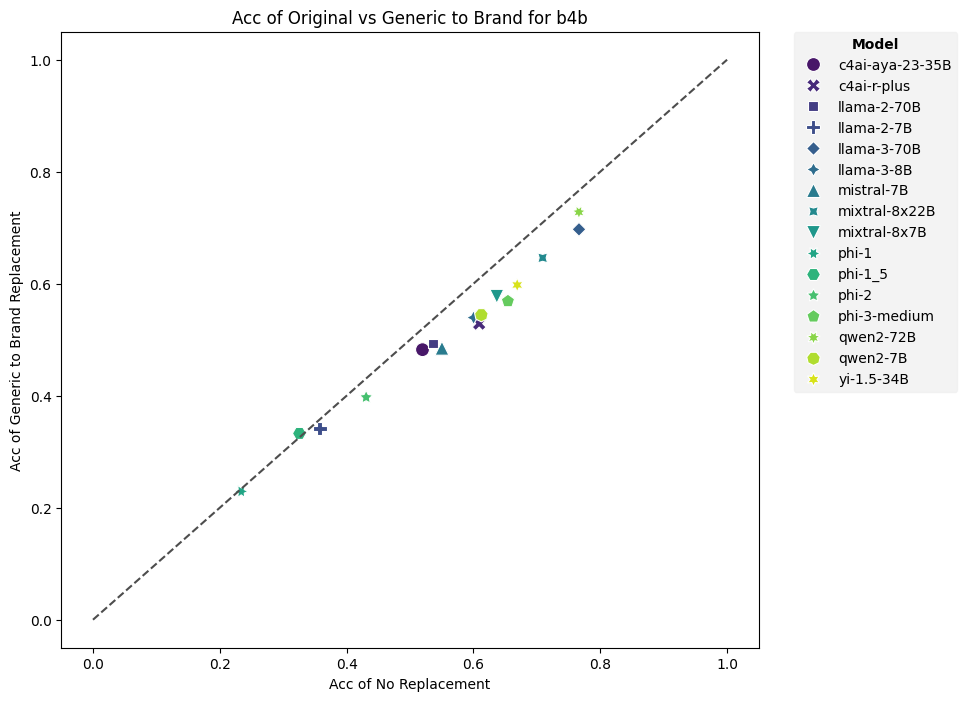

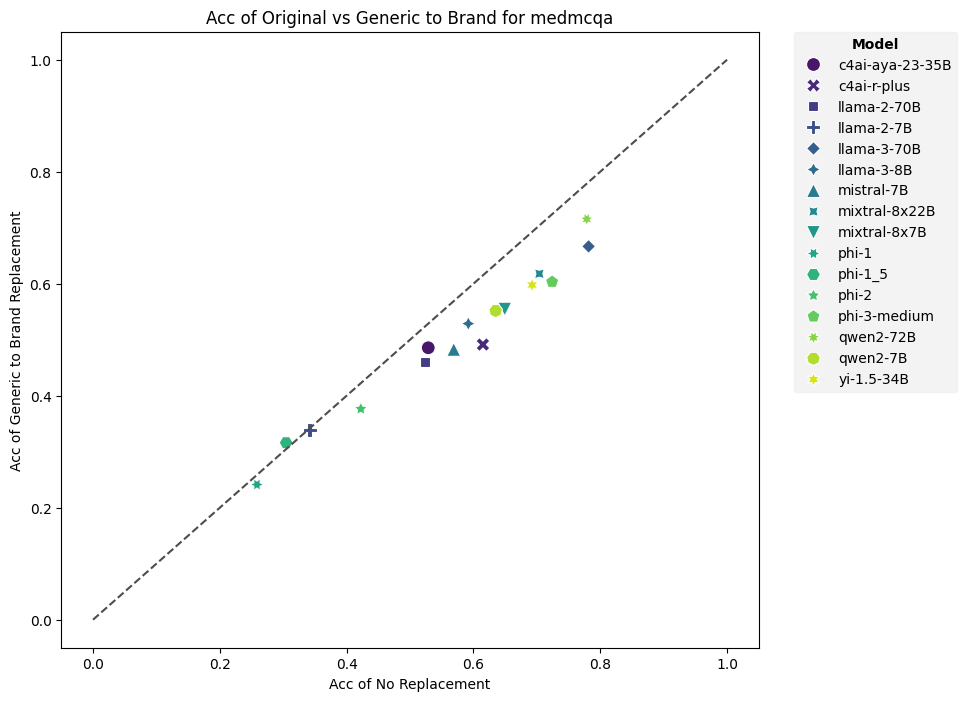

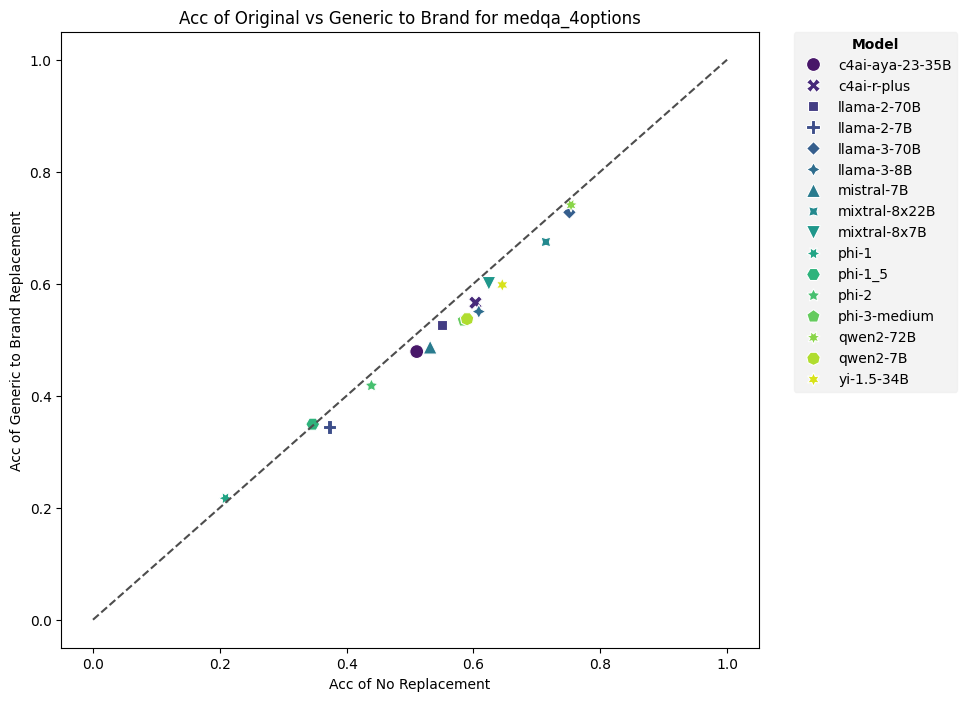

In [11]:
# Get the unique tasks
tasks = processed_results["Dataset"].unique()

for task in tasks:
    task_data = processed_results[processed_results["Dataset"] == task]

    # Setting up the figure and axis for generic_to_brand scatter plot
    plt.figure(figsize=(9, 8))
    ax2 = sns.scatterplot(
        data=task_data,
        x="none",
        y="generic_to_brand",
        hue="Model",
        style="Model",
        palette="viridis",
        s=100,
    )
    ax2.plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal line
    ax2.set_title(f"Acc of Original vs Generic to Brand for {task}")
    ax2.set_xlabel("Acc of No Replacement")
    ax2.set_ylabel("Acc of Generic to Brand Replacement")

    # Configure and place the legend outside the plot with a grey background
    legend = ax2.legend(
        title="Model", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, frameon=True
    )
    legend.get_frame().set_color("#f0f0f0")  # Set legend background color
    plt.setp(legend.get_title(), weight="bold")  # Make legend title bold
    plt.savefig(f"plots/{task}_generic_to_brand.png")
    plt.show()  # Display the plot in the notebook

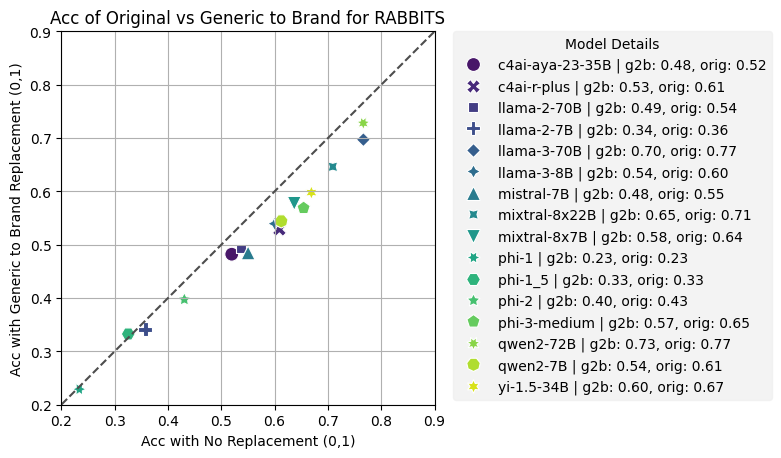

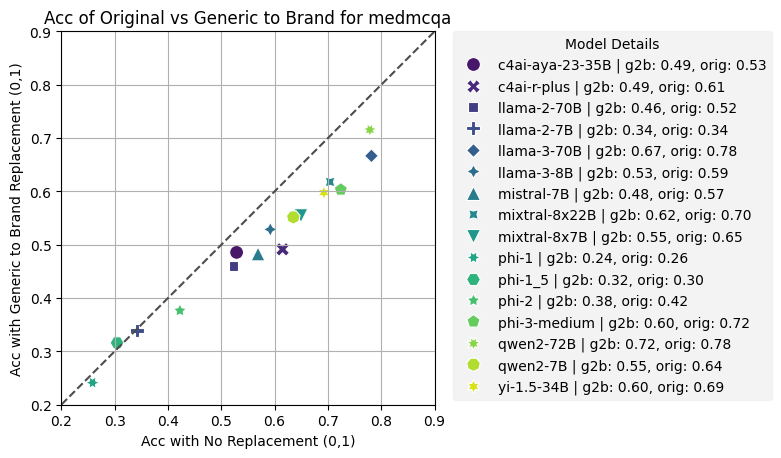

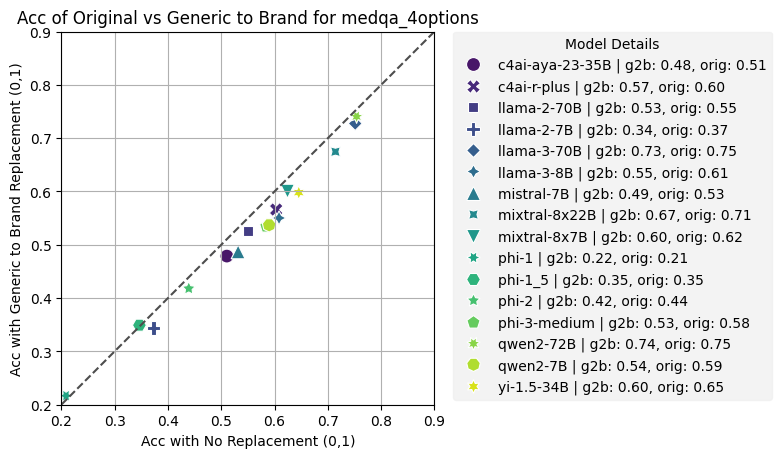

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assume 'processed_results' is your DataFrame
processed_results["Model_g2b_detail"] = processed_results.apply(
    lambda x: f"{x['Model']} | g2b: {x['generic_to_brand']:.2f}, orig: {x['none']:.2f}",
    axis=1,
)

# Get the unique tasks
tasks = processed_results["Dataset"].unique()

for task in tasks:
    task_data = processed_results[processed_results["Dataset"] == task]

    # Scatter plot for generic_to_brand vs none
    plt.figure(figsize=(8, 8))
    ax2 = sns.scatterplot(
        data=task_data,
        x="none",
        y="generic_to_brand",
        hue="Model_g2b_detail",  # Use detailed label for hue
        style="Model_g2b_detail",  # Use detailed label for style
        palette="viridis",
        s=100,
    )
    ax2.set_xlim([0.2, 0.9])  # Set x-axis range
    ax2.set_ylim([0.2, 0.9])
    ax2.plot([0, 1], [0, 1], ls="--", c=".3")  # Diagonal reference line
    ax2.set_aspect("equal", adjustable="box")
    if task == "b4b":
        ax2.set_title(f"Acc of Original vs Generic to Brand for RABBITS", loc="center")
    else:
        ax2.set_title(f"Acc of Original vs Generic to Brand for {task}", loc="center")
    ax2.set_xlabel("Acc with No Replacement (0,1)")
    ax2.set_ylabel("Acc with Generic to Brand Replacement (0,1)")
    ax2.grid(True)

    # Configure and place the legend outside the plot
    legend = ax2.legend(
        title="Model Details",
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.0,
        frameon=True,
    )
    legend.get_frame().set_color("#f0f0f0")
    plt.tight_layout()
    plt.savefig(f"plots/{task}_generic_to_brand.png")
    plt.show()

In [13]:
# read in keywords count for each dataset (raw file in b4b repo)
keywords_count = pd.read_csv("keywords_count_test.csv")

keywords_count

,dataset,split,n_questions,keywords,total_keyword_length,brand_keywords_count,generic_keywords_count
0,medmcqa,test,780,"['carbamide', 'ofloxacin', 'lamivudine', 'nevi...",1359,67,1292
1,bigbio/pubmed_qa,test,23,"['digoxin', 'supreme', 'methotrexate', 'fenofi...",23,1,22
2,GBaker/MedQA-USMLE-4-options-hf,test,508,"['hydrochlorothiazide', 'chlorthalidone', 'ato...",1169,16,1153
3,augtoma/usmle_step_1,test,24,"['levodopa', 'carbidopa', 'metformin', 'insuli...",39,1,38
4,augtoma/usmle_step_2,test,48,"['insulin', 'ciprofloxacin', 'fentanyl', 'prop...",89,0,89
5,augtoma/usmle_step_3,test,50,"['acyclovir', 'acyclovir', 'aspirin', 'levetir...",107,1,106
6,hails/mmlu_no_train/anatomy,test,3,"['fibrinogen', 'propel', 'insulin', 'fibrinoge...",3,1,2
7,hails/mmlu_no_train/clinical_knowledge,test,5,"['ropinirole', 'paracetamol', 'morphine', 'ins...",5,1,4
8,hails/mmlu_no_train/professional_medicine,test,56,"['sulfasalazine', 'ibuprofen', 'dextrose', 'wa...",97,0,97


## finetuned models

In [14]:
models = [
    "meta-llama/Meta-Llama-3-8B",
    "meta-llama/Meta-Llama-3-70B",
    "aaditya/Llama3-OpenBioLLM-70B",
    "johnsnowlabs/JSL-MedLlama-3-8B-v9",
    "ProbeMedicalYonseiMAILab/medllama3-v20",
]

model_name_map = {
    "meta-llama-Meta-Llama-3-8B": "llama-3-8B",
    "meta-llama-Meta-Llama-3-70B": "llama-3-70B",
    "aaditya-Llama3-OpenBioLLM-70B": "llama-3-70B-sft1",
    "johnsnowlabs-JSL-MedLlama-3-8B-v9": "llama-3-8B-sft1",
    "ProbeMedicalYonseiMAILab-medllama3-v20": "llama-3-8B-sft2",
}

In [15]:
# Initialize an empty DataFrame to store the final results
results_df = pd.DataFrame(columns=["Dataset", "Metric", "Value", "Model"])

# replace model / with - in the model name
for i in range(len(models)):
    models[i] = models[i].replace("/", "-")

# Load and store the model results
for model in models:
    for direction in replacement_directions:
        df_model_results = load_model_results(model, direction)
        if not df_model_results.empty:
            results_df = pd.concat([results_df, df_model_results], ignore_index=True)

# Save the results to a CSV file
# results_output_file_path = "tables/all_model_results.csv"
# results_df.to_csv(results_output_file_path, index=False)

print("\nModel Results found:")
print(results_df["Model"].unique())

processed_results = process_results(results_df)
# processed_results
# # Assume processed_results is a pandas DataFrame and 'Model' is one of its columns
processed_results["Model"] = (
    processed_results["Model"].map(model_name_map).fillna(processed_results["Model"])
)

processed_results

# # sort by dataset and model
# processed_results = processed_results.sort_values(by=["Dataset", "Model"])

# # processed_results_output_file_path = "tables/processed_model_results.csv"

# # Save the processed results to a CSV file
# # processed_results.to_csv(processed_results_output_file_path, index=False)
# processed_results


Model Results found:
['meta-llama-Meta-Llama-3-8B' 'meta-llama-Meta-Llama-3-70B'
 'aaditya-Llama3-OpenBioLLM-70B' 'johnsnowlabs-JSL-MedLlama-3-8B-v9'
 'ProbeMedicalYonseiMAILab-medllama3-v20']


Direction,Dataset,Model,generic_to_brand,none
0,medmcqa,llama-3-8B-sft2,0.652299,0.801724
1,medmcqa,llama-3-70B-sft1,0.632184,0.738506
2,medmcqa,llama-3-8B-sft1,0.640805,0.770115
3,medmcqa,llama-3-70B,0.666667,0.781609
4,medmcqa,llama-3-8B,0.528736,0.591954
5,medqa_4options,llama-3-8B-sft2,0.764550,0.902116
6,medqa_4options,llama-3-70B-sft1,0.708995,0.753968
7,medqa_4options,llama-3-8B-sft1,0.706349,0.820106
8,medqa_4options,llama-3-70B,0.727513,0.751323
9,medqa_4options,llama-3-8B,0.550265,0.608466
